# Operator objects (Legacy)

## Overview

Before introducing the `fn` API and the `pipeline_def` decorator, DALI used Operator Objects API. It more closely resembles internals of DALI but is harder to use. As you may find some code samples written in this old API, example below is a quick reference. It goes through the same steps as Getting Started page but with Operator Objects API.

### Defining the pipeline

Let us start with defining a very simple pipeline for classifier determining whether a picture contains dog or a cat.

We prepared a directory structure containing pictures of dogs and cats:

In [1]:
import os.path
import fnmatch

for root, dir, files in os.walk("data/images"):
        depth = root.count('/')
        ret = ""
        if depth > 0:
            ret += "  " * (depth - 1) + "|-"
        print (ret + root)
        for items in fnmatch.filter(files, "*"):
                print (" " * len(ret) + "|-" + items)

|-data/images
  |-file_list.txt
  |-data/images/dog
    |-dog_1.jpg
    |-dog_8.jpg
    |-dog_5.jpg
    |-dog_9.jpg
    |-dog_6.jpg
    |-dog_3.jpg
    |-dog_2.jpg
    |-dog_4.jpg
    |-dog_7.jpg
    |-dog_11.jpg
    |-dog_10.jpg
  |-data/images/kitten
    |-cat_10.jpg
    |-cat_6.jpg
    |-cat_3.jpg
    |-cat_8.jpg
    |-cat_1.jpg
    |-cat_4.jpg
    |-cat_2.jpg
    |-cat_5.jpg
    |-cat_7.jpg
    |-cat_9.jpg


Our simple pipeline will read images from this directory, decode them and return (image, label) pairs.

In [2]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

image_dir = "data/images"
batch_size = 8

class SimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.readers.File(file_root = image_dir)
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)

The `SimplePipeline` class is a subclass of `dali.pipeline.Pipeline`, which provides most of the methods to create and launch a pipeline. The only 2 methods that we need to implement is the constructor and `define_graph` function.

In the constructor we first call our superclass constructor, in order to set global parameters of the pipeline:

* batch size,
* number of threads used to perform computation on the CPU,
* which GPU device to use (`SimplePipeline` does not yet use GPU for compute though)
* seed for random number generation
 
In the constructor we also define member variables of our `SimplePipeline` class as operations defined in `dali.ops` module:

* `readers.File` - traverses the directory and returns pairs of (encoded image, label)
* `ImageDecoder` - takes an encoded image input and outputs decoded RGB image

In the `define_graph` function we define the actual flow of computation:
```
jpegs, labels = self.input()
```
uses our `input` operation to create `jpegs` (encoded images) and `labels`.
```
images = self.decode(jpegs)
```
Next, we use the `decode` operation to create `images` (decoded RGB images).
```
return (images, labels)
```
Finally, we specify which of the intermediate variables should be returned as outputs of the pipeline.

### Building the pipeline

In order to use our `SimplePipeline`, we need to build it. This is achieved by calling `build` function.

In [3]:
pipe = SimplePipeline(batch_size, 1, 0)
pipe.build()

### Running the pipeline

After the pipeline is built, we can run it to get the batch of results.

In [4]:
pipe_out = pipe.run()
print(pipe_out)

(<nvidia.dali.backend_impl.TensorListCPU object at 0x7fe7f8ac63e8>, <nvidia.dali.backend_impl.TensorListCPU object at 0x7fe7f8ac6420>)


The output of the pipeline, which we saved to `pipe_out` variable, is a list of 2 elements (as expected - we specified 2 outputs in `define_graph` function in `SimplePipeline` class). Both of these elements are `TensorListCPU` objects - each contains a list of tensors on the CPU.

In order to show the results (just for debugging purposes - during the actual training we would not do that step, as it would make our batch of images do a round trip from GPU to CPU and back) we can send our data from DALI's Tensor to NumPy array. Not every `TensorList` can be accessed that way though - `TensorList` is more general than NumPy array and can hold tensors with different shapes. In order to check whether we can send it to NumPy directly, we can call the `is_dense_tensor` function of `TensorList`

In [5]:
images, labels = pipe_out
print("Images is_dense_tensor: " + str(images.is_dense_tensor()))
print("Labels is_dense_tensor: " + str(labels.is_dense_tensor()))

Images is_dense_tensor: False
Labels is_dense_tensor: True


As it turns out, `TensorList` containing labels can be represented by a tensor, while the `TensorList` containing images cannot.

Let us see, what is the shape and contents of returned labels.

In [6]:
import numpy as np

labels_tensor = labels.as_tensor()

print (labels_tensor.shape())
print (np.array(labels_tensor))

[8, 1]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In order to see the images, we will need to loop over all tensors contained in `TensorList`, accessed with its `at` method.

In [7]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

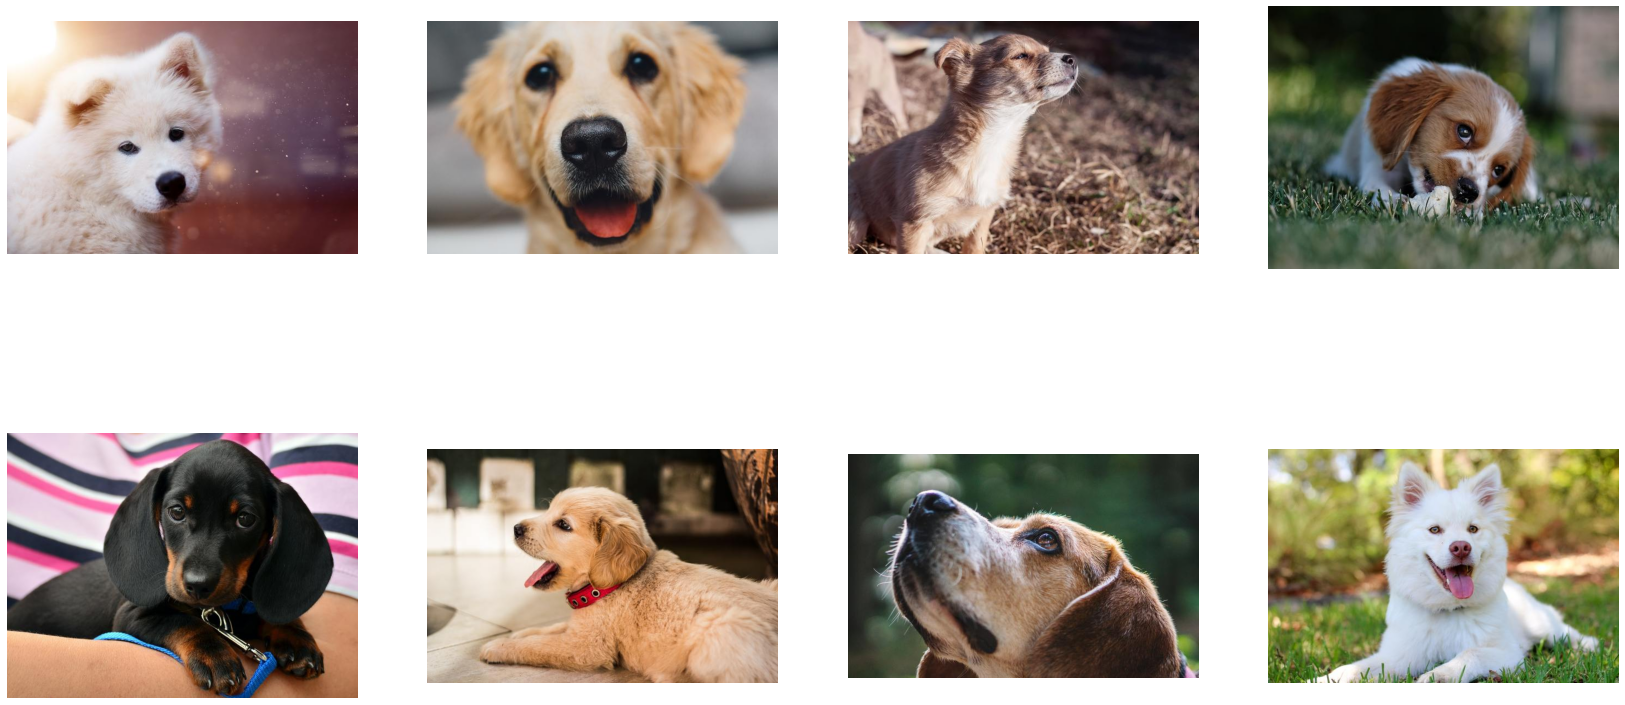

In [8]:
show_images(images)

## Adding augmentations

### Random shuffle

As we can see from the example above, the first batch of images returned by our pipeline contains only dogs. That is because we did not shuffle our dataset, and so `FileReader` returns images in order in which it encountered them while traversing the directory structure.

Let us make a new pipeline, that will change that.

In [9]:
class ShuffledSimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ShuffledSimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.readers.File(file_root = image_dir, random_shuffle = True, initial_fill = 21)
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)

We made 2 changes to the `SimplePipeline` to obtain `ShuffledSimplePipeline` - we added 2 parameters to the `FileReader` operation

* `random_shuffle` enables shuffling of images in the reader. Shuffling is performed using a buffer of images read from disk. When reader is asked to provide a next image, it randomly selects an image from the buffer, outputs it and immediately replaces that spot in a buffer with a freshly read image.
* `initial_fill` sets the capacity of the buffer. The default value of this parameter (1000), well suited for datasets containing thousands of examples, is too big for our very small dataset, which contains only 21 images. This could result in frequent duplicates in the returned batch. That is why in this example we set it to the size of our dataset.
 
Let us test the result of this modification.

In [10]:
pipe = ShuffledSimplePipeline(batch_size, 1, 0)
pipe.build()

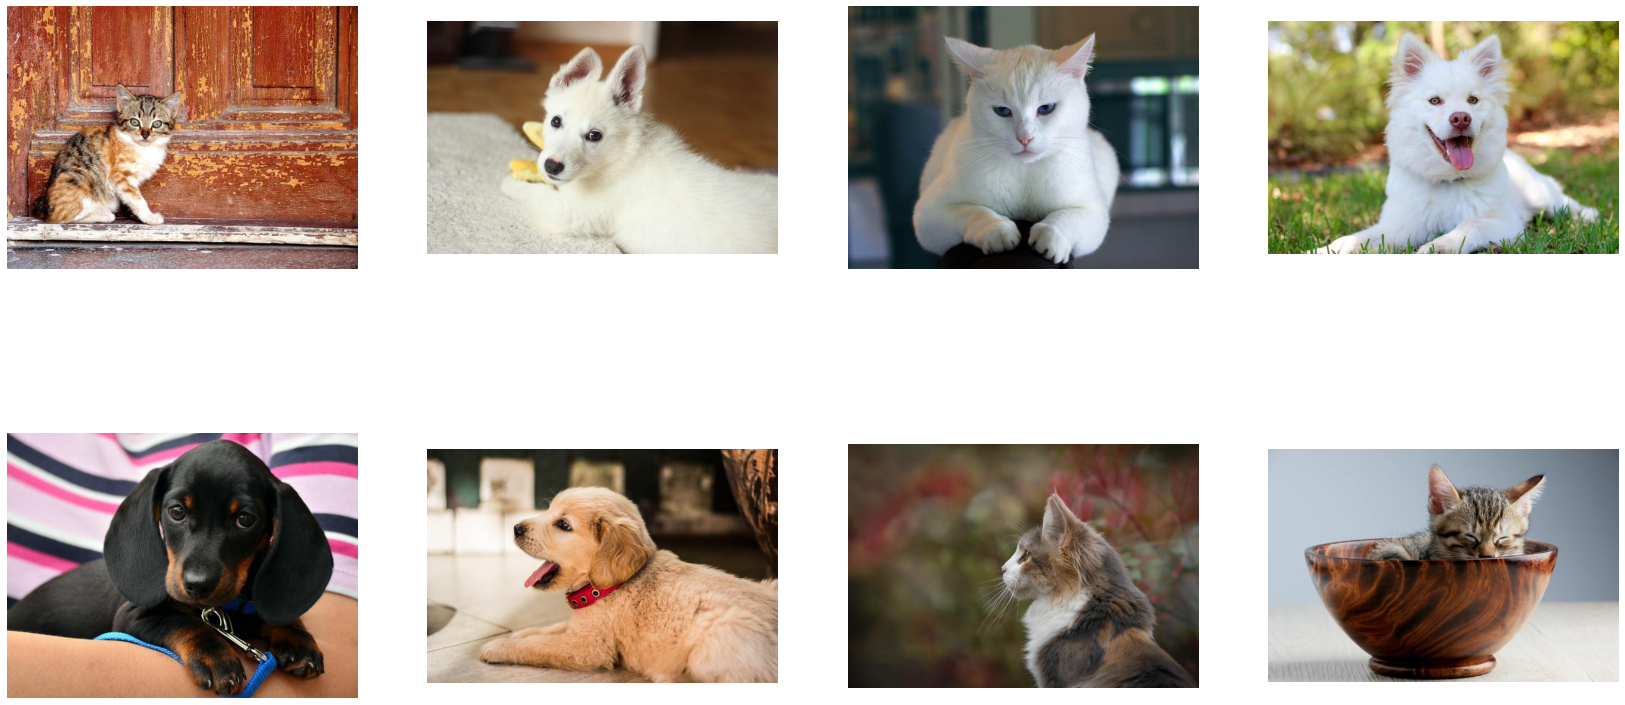

In [11]:
pipe_out = pipe.run()
images, labels = pipe_out
show_images(images)

Now the images returned by the pipeline are shuffled properly.

### Augmentations

DALI can not only read images from disk and batch them into tensors, it can also perform various augmentations on those images to improve Deep Learning training results.

One example of such augmentations is rotation. Let us make a new pipeline, which rotates the images before outputting them.

In [12]:
class RotatedSimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(RotatedSimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.readers.File(file_root = image_dir, random_shuffle = True, initial_fill = 21)
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)
        self.rotate = ops.Rotate(angle = 10.0)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        rotated_images = self.rotate(images)
        return (rotated_images, labels)

To do that, we added a new operation to our pipeline: `dali.ops.Rotate`. To obtain information on required and optional arguments of any operation provided by DALI, we can use `help` function.

In [13]:
help(ops.Rotate)

Help on class Rotate in module nvidia.dali.ops:

class Rotate(builtins.object)
 |  Rotates the images by the specified angle.
 |  
 |  This operator supports volumetric data.
 |  
 |  Supported backends
 |   * 'cpu'
 |   * 'gpu'
 |  
 |  
 |  Keyword args
 |  ------------
 |  `angle` : float or TensorList of float
 |      Angle, in degrees, by which the image is rotated.
 |      
 |      For two-dimensional data, the rotation is counter-clockwise, assuming the top-left corner is
 |      at ``(0,0)``. For three-dimensional data, the ``angle`` is a positive rotation around the provided
 |      axis.
 |  `axis` : float or list of float or TensorList of float, optional, default = []
 |      Applies **only** to three-dimension and is the axis
 |      around which to rotate the image.
 |      
 |      The vector does not need to be normalized, but it must have a non-zero length.
 |      Reversing the vector is equivalent to changing the sign of ``angle``.
 |      
 |  `bytes_per_sample_hint`

As we can see, `Rotate` can take multiple arguments, but only one of them, `angle`, is required - it tells the operator how much it should rotate images.

Let us test the newly created pipeline:

In [14]:
pipe = RotatedSimplePipeline(batch_size, 1, 0)
pipe.build()

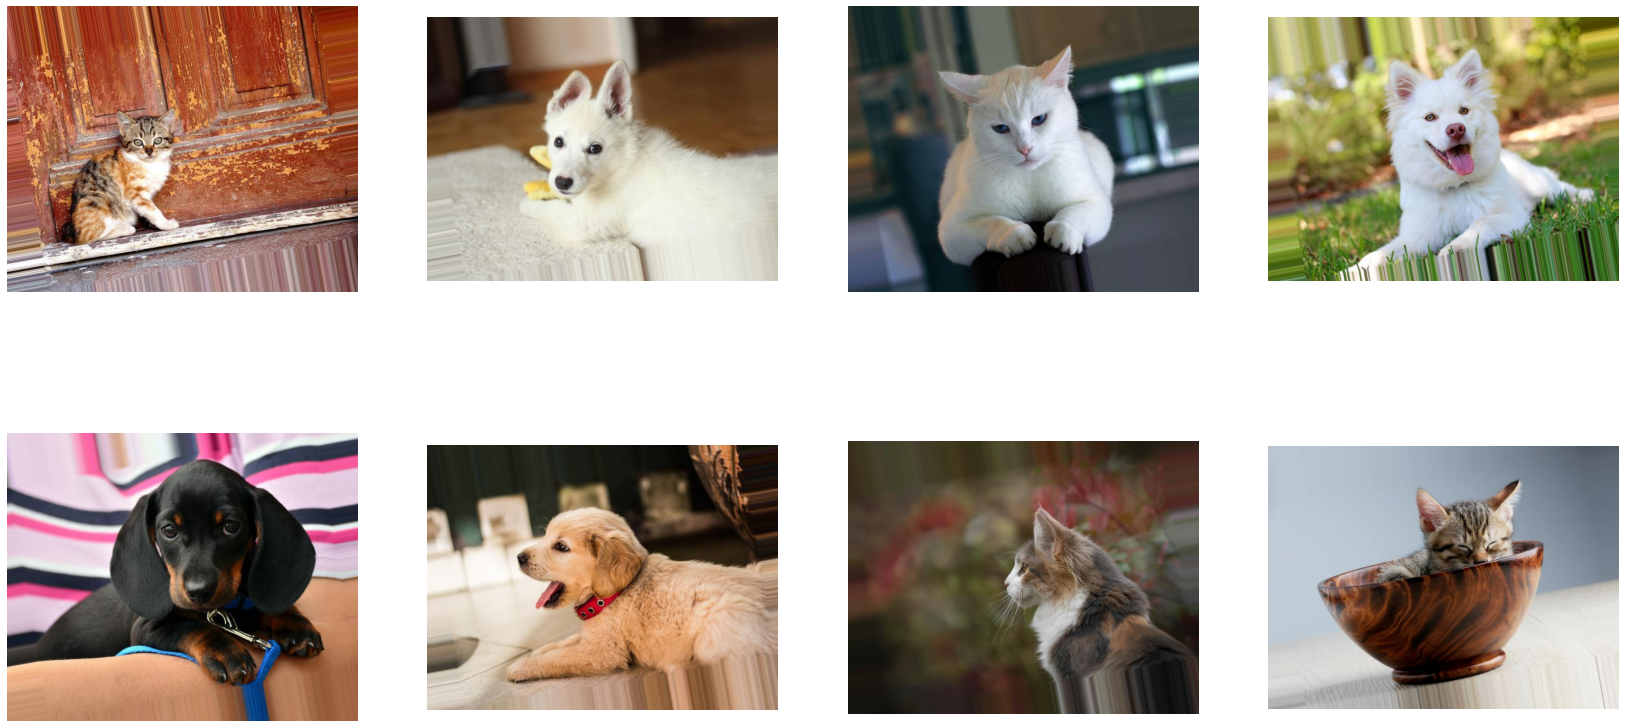

In [15]:
pipe_out = pipe.run()
images, labels = pipe_out
show_images(images)

### Tensors as arguments and Random Number Generation

Rotating every image by 10 degrees is not that interesting. To make a meaningful augmentation, we would like an operator that rotates our images by a random angle in a given range. 

The `help` output for `Rotate` operation tells us, that `angle` parameter can accept `float` or `float tensor` types of values. The second option, `float tensor`, enables us to feed the operator with different rotation angles for every image, via a tensor produced by other support operation.

Random number generators are examples of support operations that one can use with DALI. Let us use `dali.ops.random.Uniform` to make a pipeline with random rotation.

In [16]:
class RandomRotatedSimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(RandomRotatedSimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.readers.File(file_root = image_dir, random_shuffle = True, initial_fill = 21)
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)
        self.rotate = ops.Rotate()
        self.rng = ops.random.Uniform(range = (-10.0, 10.0))

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        angle = self.rng()
        rotated_images = self.rotate(images, angle = angle)
        return (rotated_images, labels)

This time, instead of providing a fixed value for the `angle` argument in the constructor, we set it to the output of the `dali.ops.random.Uniform` operator.

Let us check the result:

In [17]:
pipe = RandomRotatedSimplePipeline(batch_size, 1, 0)
pipe.build()

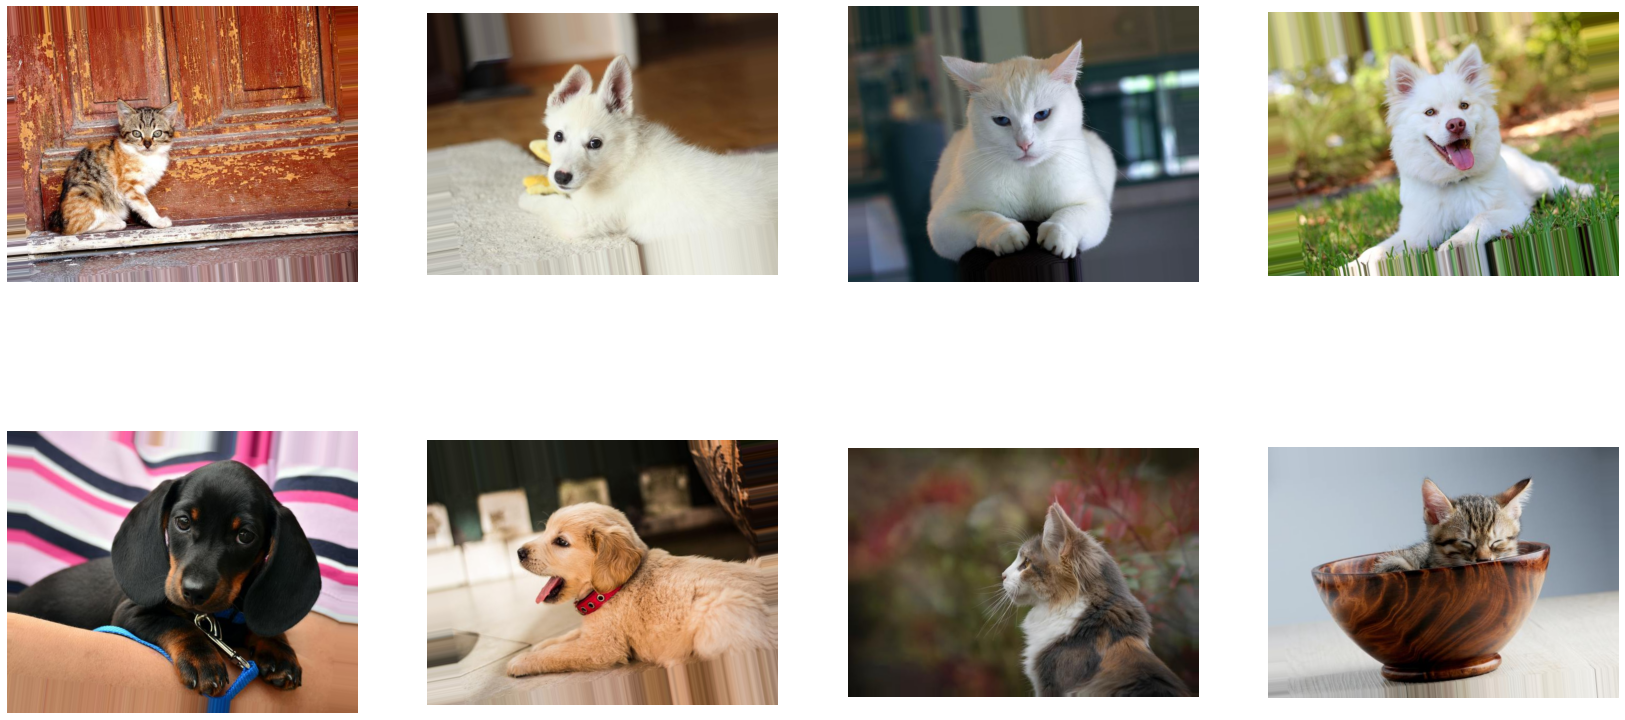

In [18]:
pipe_out = pipe.run()
images, labels = pipe_out
show_images(images)

This time, the rotation angle is randomly selected from a value range.

## GPU acceleration

DALI offers access to GPU accelerated operators, that can increase the speed of the input and augmentation pipeline and let it scale to multi-GPU systems.

### Copying tensors to GPU

Let us modify the previous example of the `RandomRotatedSimplePipeline` to use GPU for rotation operator.

In [19]:
class RandomRotatedGPUPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(RandomRotatedGPUPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.readers.File(file_root = image_dir, random_shuffle = True, initial_fill = 21)
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)
        self.rotate = ops.Rotate(device = "gpu")
        self.rng = ops.random.Uniform(range = (-10.0, 10.0))

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        angle = self.rng()
        rotated_images = self.rotate(images.gpu(), angle = angle)
        return (rotated_images, labels)

In order to tell DALI that we want to use GPU, we needed to make 2 changes to the pipeline:

* we added a `device = "gpu"` parameter to the `Rotate` operation
* we changed input to the rotate from `images`, which is a tensor on the CPU, to `images.gpu()` which copies it to the GPU

In [20]:
pipe = RandomRotatedGPUPipeline(batch_size, 1, 0)
pipe.build()

In [21]:
pipe_out = pipe.run()
print(pipe_out)

(<nvidia.dali.backend_impl.TensorListGPU object at 0x7fe757b19500>, <nvidia.dali.backend_impl.TensorListCPU object at 0x7fe757b19570>)


`pipe_out` still contains 2 `TensorList`s, but this time the first output, result of the `Rotate` operation, is on the GPU. We cannot access contents of `TensorListGPU` directly from the CPU, so in order to visualize the result we need to copy it to the CPU by using `as_cpu` method.

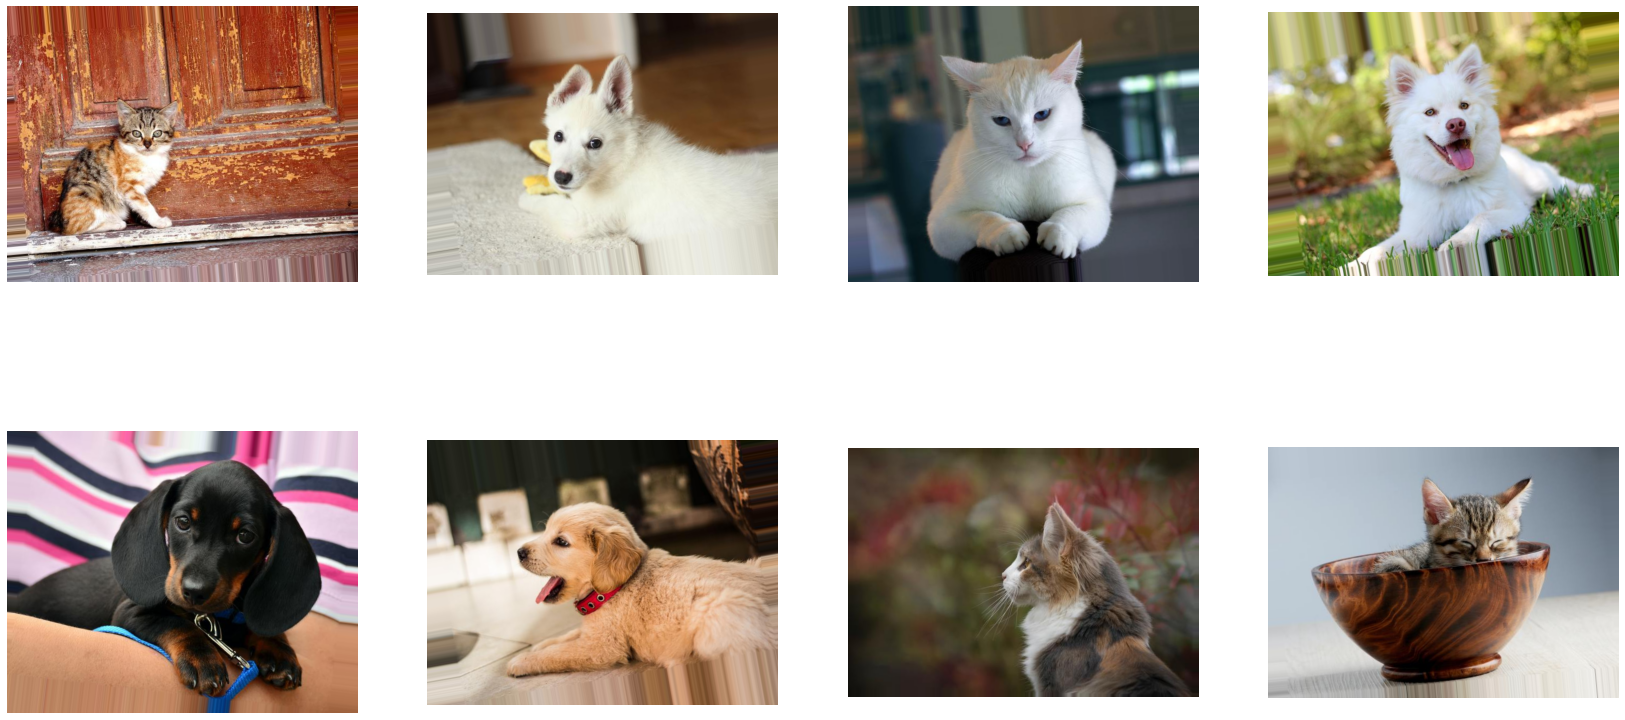

In [22]:
images, labels = pipe_out
show_images(images.as_cpu())

#### Important notice
DALI does not support moving the data from the GPU to the CPU within the pipeline. In all execution paths CPU operator cannot follow GPU operator.

### Hybrid decoding

Sometimes, especially for higher resolution images, decoding images stored in JPEG format may become a bottleneck. To address this problem, nvJPEG and nvJPEG2000 libraries were developed. They split the decoding process between CPU and GPU, significantly reducing the decoding time.

Specifying "mixed" device parameter in `ImageDecoder` enables nvJPEG support. Other file formats are still decoded on the CPU.

In [23]:
class HybridPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(HybridPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.readers.File(file_root = image_dir, random_shuffle = True, initial_fill = 21)
        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        # images are on the GPU
        return (images, labels)

`ImageDecoder` with `device=mixed` uses a hybrid approach of computation that employs both the CPU and the GPU. This means that it accepts CPU inputs, but returns GPU outputs. That is why `images` objects returned from the pipeline are of type `TensorListGPU`.

In [24]:
pipe = HybridPipeline(batch_size, 1, 0)
pipe.build()

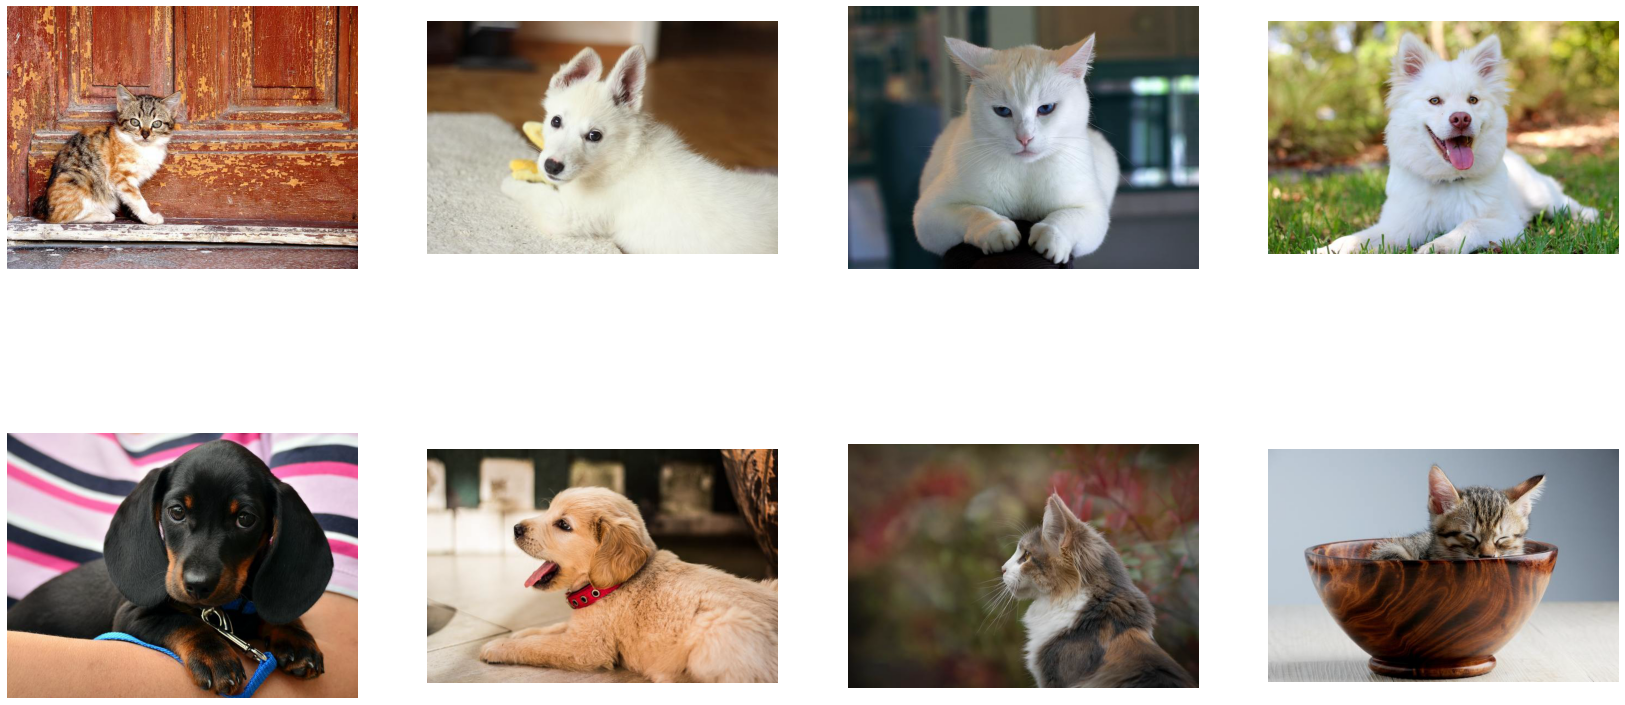

In [25]:
pipe_out = pipe.run()
images, labels = pipe_out
show_images(images.as_cpu())

Let us compare the speed of `ImageDecoder` for 'cpu' and 'mixed' backends by measuring speed of `ShuffledSimplePipeline` and `HybridPipeline` with 4 CPU threads.

In [26]:
from timeit import default_timer as timer

test_batch_size = 64

def speedtest(pipeclass, batch, n_threads):
    pipe = pipeclass(batch, n_threads, 0)
    pipe.build()
    # warmup
    for i in range(5):
        pipe.run()
    # test
    n_test = 20
    t_start = timer()
    for i in range(n_test):
        pipe.run()
    t = timer() - t_start
    print("Speed: {} imgs/s".format((n_test * batch)/t))

In [27]:
speedtest(ShuffledSimplePipeline, test_batch_size, 4)

Speed: 3148.0450036694533 imgs/s


In [28]:
speedtest(HybridPipeline, test_batch_size, 4)

Speed: 5521.192268335292 imgs/s


As we can see, moving the decoding partially to the GPU resulted in significant speedup.